# Un premier graphe de compositeurs

In [31]:
from bs4 import BeautifulSoup
import requests
import re
import networkx as nx
import spacy
import numpy as np
import math
import time
import pickle
import json
from ipysigma import Sigma
import spacy

## Variables globales

In [2]:
#Dictionnaire des propriétés souhaitées
dico_props = {"pays" : "P27",
              "nom" : "P735",
              "prenom" : "P734",
              "date de naissance" : "P569",
              "genre" : "P136",
              "influences" : "P737",
              "oeuvres":"P800",
              "religion" : "P140",
              "étudiant de" : "P1066",
              "professeur de": "P802",
              "écoles" : "P69",
              "domaines" : "P101",
              "institut" : "P108",
              "début de carrière" : "P2031",
              "langues" : "P1412",
              "lieux de vie" : "P551",
              "mouvement" : "P135",
              "métiers" : "P106"}

In [3]:
def verbose(message,verb):
    if verb:
        print(message)

In [39]:
def find_id(name):
    """Récupère l'id d'un compositeur à partir de son nom"""
    url = f"https://www.wikidata.org/w/index.php?search={name[0]}+{name[1]}&title=Special%3ASearch&ns0=1&ns120=1"
    page = requests.get(url)
    soup = BeautifulSoup(page.content, "html.parser")
    try :
        bloc = soup.find("div", class_ = "mw-search-result-heading")
        group = bloc.find("a")
        if group is None:
            return None
        else:
            return group["href"][6:]
    except:
        print(f"Erreur sur le nom {name[0]} {name[1]}")
        return None

In [40]:
print(find_id(("Johann-Sebastian","Bach")))
print(find_id(("Richard", "Wagner")))

Q1339
Q1511


## Récupération des noms depuis Classic Cat

In [6]:
url = requests.get("https://www.classiccat.net/composers.php")
page = BeautifulSoup(url.content, "html.parser")
li_compo = page.find_all("a", href = True)
compos = []
for lien in li_compo:
    text = lien.get_text()
    if "," in text:
        if len(compos)>0:
            if text[0] < compos[-1][0]:
                break
        compos.append(text)


In [7]:
composers = [(compo.split(",")[1],compo.split(",")[0])  for compo in compos]

## Complétion des données à partir de l'endpoint Sparqle de Wikidata

In [8]:
def actualise_prop(dico,prop,nameprop,id):
    """Actualise le dictionnaire avec la propriété prop"""
    sparql_endpoint = "https://query.wikidata.org/sparql"
    query = f"""
    SELECT ?prop ?propLabel WHERE {{
        wd:{id} wdt:{prop} ?prop.
        SERVICE wikibase:label {{ bd:serviceParam wikibase:language "[AUTO_LANGUAGE],fr". }}
    }}
    """
    response = requests.get(sparql_endpoint, params={'query': query, 'format': 'json'})
    time.sleep(0.05)
    li_rep = []
    if response.status_code == 200:
        data = response.json()
        for item in data['results']['bindings']:
            li_rep.append((item['prop']['value'][31:],item['propLabel']['value']))
        dico[nameprop] = li_rep
    else:
        dico[nameprop] = None
        print("Erreur lors de la requête SPARQL:", response.status_code)

In [9]:
name = ("Johann-Sebastian","Bach")
id = find_id(name)
dico = {}
actualise_prop(dico,'P27','pays',id)
dico

{'pays': [('Q12548', 'Saint-Empire romain germanique'),
  ('Q696651', 'duché de Saxe-Eisenach')]}

In [10]:
def create_profile(name,dico_props):
    """Créé le profil d'un compositeur à partir des propriétés voulues et de son nom"""
    dico = {"prénom" : name[0], "nom" : name[1]}
    id = find_id(name)
    dico["id"] = id
    if id is None:
        print("Erreur, aucun dictonnaire renvoyé")
    for nom,prop in dico_props.items():
        actualise_prop(dico, prop, nom, id)
    return dico

In [11]:
create_profile(("Johann-Sebastian","Bach"),dico_props)

Erreur lors de la requête SPARQL: 429
Erreur lors de la requête SPARQL: 429
Erreur lors de la requête SPARQL: 429
Erreur lors de la requête SPARQL: 429
Erreur lors de la requête SPARQL: 429
Erreur lors de la requête SPARQL: 429
Erreur lors de la requête SPARQL: 429


{'prénom': 'Johann-Sebastian',
 'nom': [('Q4844560', 'Sebastian'), ('Q11122389', 'Johann')],
 'id': 'Q1339',
 'pays': [('Q12548', 'Saint-Empire romain germanique'),
  ('Q696651', 'duché de Saxe-Eisenach')],
 'prenom': [('Q1409748', 'Bach')],
 'date de naissance': [('', '1685-03-31T00:00:00Z')],
 'genre': [('Q8361', 'musique baroque')],
 'influences': [('Q1340', 'Antonio Vivaldi'),
  ('Q76485', 'Johann Pachelbel'),
  ('Q508635', 'Johann Georg Pisendel')],
 'oeuvres': [('Q75464', 'Sonates et partitas pour violon seul'),
  ('Q208224', 'concertos brandebourgeois'),
  ('Q211971', 'Le Clavier bien tempéré'),
  ('Q213728', 'Variations Goldberg'),
  ('Q310549', 'Messe en si mineur'),
  ('Q379111', 'Passion selon Saint Matthieu'),
  ('Q392734', 'Toccata et fugue en ré mineur'),
  ('Q465878', "L'Art de la fugue"),
  ('Q642010', 'Oratorio de Noël'),
  ('Q693675', "L'Offrande musicale"),
  ('Q756843', 'Suites pour violoncelle seul'),
  ('Q865333', 'Passion selon saint Jean'),
  ('Q892166', 'Jesu, 

In [12]:
def create_profile_id(id,dico_props):
    """Créé le profil d'un compositeur à partir des propriétés voulues et de son id"""
    dico = {"id" : id}
    if id is None:
        print("Erreur, aucun dictonnaire renvoyé")
    for nom,prop in dico_props.items():
        actualise_prop(dico, prop, nom, id)
    return dico

In [13]:
create_profile_id("Q38193",dico_props)

Erreur lors de la requête SPARQL: 429
Erreur lors de la requête SPARQL: 429
Erreur lors de la requête SPARQL: 429
Erreur lors de la requête SPARQL: 429
Erreur lors de la requête SPARQL: 429
Erreur lors de la requête SPARQL: 429
Erreur lors de la requête SPARQL: 429
Erreur lors de la requête SPARQL: 429
Erreur lors de la requête SPARQL: 429
Erreur lors de la requête SPARQL: 429
Erreur lors de la requête SPARQL: 429
Erreur lors de la requête SPARQL: 429
Erreur lors de la requête SPARQL: 429
Erreur lors de la requête SPARQL: 429
Erreur lors de la requête SPARQL: 429


{'id': 'Q38193',
 'pays': None,
 'nom': None,
 'prenom': None,
 'date de naissance': [('', '1788-02-22T00:00:00Z')],
 'genre': None,
 'influences': None,
 'oeuvres': None,
 'religion': None,
 'étudiant de': [],
 'professeur de': None,
 'écoles': None,
 'domaines': None,
 'institut': None,
 'début de carrière': None,
 'langues': None,
 'lieux de vie': [('Q1055', 'Hambourg'),
  ('Q1792', 'Gdańsk'),
  ('Q1794', 'Francfort-sur-le-Main')],
 'mouvement': None,
 'métiers': None}

## Complétion plus rapide à l'aide de l'API Wikidata

In [14]:
def find_all_properties(entity_id,dico_props = None,lg = "fr"):
    url = f"https://www.wikidata.org/w/api.php?action=wbgetentities&format=json&ids={entity_id}"
    response = requests.get(url)
    properties = {"id" : entity_id}
    if response.status_code == 200:
        data = response.json()
        data2 = data['entities'][entity_id]
        if 'labels' in data2 and lg in data2['labels']:
            name = data2['labels'][lg]['value']
        elif 'labels' in data2 and 'en' in data2['labels']:
            name = data2['labels']['en']['value']
        else:
            name = entity_id
        properties["nom"] = name
        if 'descriptions' in data2 and lg in data2['descriptions']:
            desc = data2['descriptions'][lg]['value']
        elif 'descriptions' in data2 and 'en' in data2['descriptions']:
            desc = data2['descriptions']['en']['value']
        else:
            desc = entity_id
        properties["description"] = desc
        claims = data['entities'][entity_id]['claims']
        for prop in claims:
            if prop.startswith("P"):
                if dico_props is None or prop in dico_props.values():
                    if len(claims[prop]) > 0:
                        properties[prop] = []
                        for item in claims[prop]:
                            if 'mainsnak' in item and 'datavalue' in item['mainsnak']:
                                value = item['mainsnak']['datavalue']
                                if value['type'] == 'wikibase-entityid':
                                    properties[prop].append(value['value']['id'])
                                elif value['type'] == 'string':
                                    properties[prop].append(value['value'])
                                elif value['type'] == 'time':
                                    properties[prop].append(value['value']['time'])
                                elif value['type'] == 'quantity':
                                    properties[prop].append(value['value']['amount'])
                                elif value['type'] == 'globe-coordinate':
                                    properties[prop].append((value['value']['latitude'], value['value']['longitude']))
                                else:
                                    properties[prop].append(value['value'])
        if dico_props is not None:
            proprietes = {"id" : entity_id, "nom complet" : name, "description" : desc}
            for name, prop in dico_props.items():
                if prop in properties:
                    proprietes[name] = properties[prop]
            return proprietes
        return properties
    else:
        print(f"Erreur lors de la récupération des propriétés : {response.status_code}")
        return None

In [15]:
dico = find_all_properties(find_id(("Richard","Wagner")), dico_props=dico_props)
dico

{'id': 'Q1511',
 'nom complet': 'Richard Wagner',
 'description': "compositeur, directeur de théâtre, écrivain, chef d'orchestre et polémiste allemand de la période romantique",
 'pays': ['Q153015', 'Q183', 'Q39', 'Q38', 'Q40'],
 'nom': ['Q1249148', 'Q11027623'],
 'prenom': ['Q2539239'],
 'date de naissance': ['+1813-05-22T00:00:00Z', '+1813-00-00T00:00:00Z'],
 'genre': ['Q1344', 'Q2142754', 'Q9730'],
 'influences': ['Q38193'],
 'oeuvres': ['Q114640', 'Q1324254', 'Q560619', 'Q327717', 'Q23085', 'Q190237'],
 'religion': ['Q75809'],
 'étudiant de': ['Q65815'],
 'professeur de': ['Q594113'],
 'écoles': ['Q154804', 'Q1526368', 'Q699668'],
 'domaines': ['Q1344', 'Q279272'],
 'institut': ['Q686522'],
 'début de carrière': ['+1832-00-00T00:00:00Z'],
 'langues': ['Q188'],
 'métiers': ['Q36834',
  'Q8178443',
  'Q158852',
  'Q11774202',
  'Q3387717',
  'Q18814623',
  'Q49757',
  'Q486748',
  'Q1350157',
  'Q18939491',
  'Q36180']}

## Génération d'un premier graphe d'influence à partir des relations d'influence de wikidata

Premiers constats : la relation d'influence est trop faible, et subitement très forte lorsqu'il s'agit de philosophes (cf. le graphe de Wagner qui est très encombré du fait de son influence sur Schopenhauer).

In [16]:
def generate_color_palette(N):
    """
    Génère une palette de N couleurs en format hexadécimal.

    :param N: Nombre de couleurs à générer
    :return: Liste de couleurs en format hexadécimal
    """
    import colorsys

    # Liste pour stocker les couleurs
    colors = []

    for i in range(N):
        # Calculer la teinte (hue) en fonction de l'index
        hue = i / N
        # Convertir HSV à RGB
        rgb = colorsys.hsv_to_rgb(hue, 1.0, 1.0)
        # Convertir RGB à hexadécimal
        hex_color = '#{:02x}{:02x}{:02x}'.format(int(rgb[0] * 255), int(rgb[1] * 255), int(rgb[2] * 255))
        colors.append(hex_color)

    return colors

In [17]:
def graph_influence(id_composer,n_max_iter=2, verb = False, lg = "fr"):
    colors  = generate_color_palette(n_max_iter+1)
    G = nx.DiGraph()
    properties = find_all_properties(id_composer, dico_props=dico_props)
    G.add_node(id_composer, **properties)
    G.nodes[id_composer]["color"] = colors[0]
    set_actuel = {id_composer}
    visites = {id_composer: properties}
    for i in range(n_max_iter):
        set_suivant = set()
        verbose(f"Compositeurs à traiter à l'étape {i}/{n_max_iter} : {set_actuel}",verb)
        for id_influ in set_actuel:
            verbose(f"Etude de {id_influ}",verb)
            if visites[id_influ] is not None and "influences" in visites[id_influ].keys():
                influences = visites[id_influ]["influences"]
                verbose(f"Les voisins de {id_influ} : {influences}",verb)
                if influences is not None:
                    for id_suivant in influences:
                        if id_suivant not in visites.keys():
                            verbose(f"Ajout de {id_suivant} dans le graphe",verb)
                            dico = find_all_properties(id_suivant, dico_props=dico_props)
                            G.add_node(id_suivant, **dico)
                            visites[id_suivant] = dico
                            G.nodes[id_suivant]["color"] = colors[i+1]
                        else:
                            verbose(print(f"{id_suivant} déjà présent dans le graphe",verb))
                        G.add_edge(id_influ, id_suivant)
                        set_suivant.add(id_suivant)
        set_actuel = set_suivant.copy()
    for node in G.nodes():
        if node in visites.keys():
            G.nodes[node].update(visites[node])
        else:
            print("Erreur !")
    return G

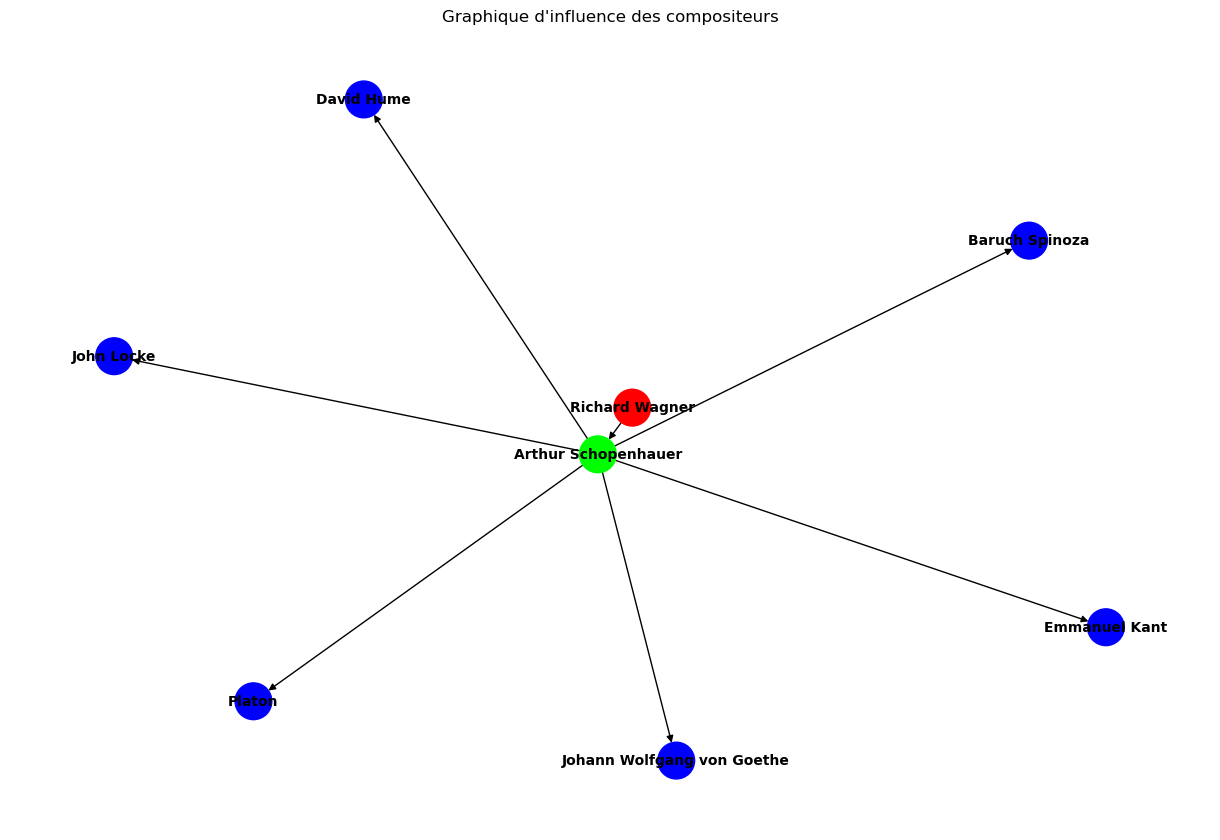

In [18]:
graph = graph_influence(find_id(("Richard","Wagner")), n_max_iter=2)

def draw_graph(graph):
    import matplotlib.pyplot as plt
    pos = nx.spring_layout(graph, seed=42)  # Positionnement des nœuds
    plt.figure(figsize=(12, 8))
    colors = [graph.nodes[n]['color'] for n in graph.nodes()]
    nx.draw(graph, pos, with_labels=True, labels = nx.get_node_attributes(graph, 'nom complet'), node_size=700, node_color=colors, font_size=10, font_weight="bold", arrows=True)
    plt.title("Graphique d'influence des compositeurs")
    plt.show()
draw_graph(graph)

## Graphe complet d'influences

In [19]:
def graphes_toutes_influences(li_compos,verb = False):
    G = nx.DiGraph()
    i=1
    for compos in li_compos:
        verbose(f"Traitement {i}/{len(li_compos)} : {compos[0]} {compos[1]}",verb)
        i+=1
        id_compos = find_id(compos)
        if id_compos is not None:
            profile = find_all_properties(id_compos, dico_props=dico_props)
            G.add_node(id_compos)
            G.nodes[id_compos].update(profile)
            G.nodes[id_compos]["color"] = "red"
            if "influences" in profile and profile["influences"] is not None:
                for influ in profile["influences"]:
                    G.add_edge(id_compos,influ)
                    profile_influ = find_all_properties(influ, dico_props=dico_props)
                    G.nodes[influ].update(profile_influ)
                    if "color" not in G.nodes[influ] :
                        G.nodes[influ]["color"] = "blue"
    #G.set_node_color('color')
    return G


In [20]:
graph = graphes_toutes_influences(composers, verb = True) #Environ 3 minutes pour 100 compositeurs
with open('graphe_influ_tot.pkl', 'wb') as f:
    pickle.dump(graph, f)

Traitement 1/766 :  Adolphe Adam
Traitement 2/766 :  Dionisio Aguado
Traitement 3/766 :  Julián Aguirre
Traitement 4/766 :  Isaac Albéniz
Traitement 5/766 :  Tomaso Albinoni
Traitement 6/766 :  Johann Georg Albrechtsberger
Traitement 7/766 :  Charles Valentin Alkan
Traitement 8/766 :  Gregorio Allegri
Traitement 9/766 :  William Alwyn
Traitement 10/766 :  Joachim Andersen
Traitement 11/766 :  Leroy Anderson
Traitement 12/766 :  Louis Andriessen
Traitement 13/766 :  Giovanni Animuccia
Traitement 14/766 :  Hans Erich Apostel
Traitement 15/766 :  Bert Appermont
Traitement 16/766 :  Jacob Arcadelt
Traitement 17/766 :  Anton Arensky
Traitement 18/766 :  Malcolm Arnold
Traitement 19/766 :  Samuel Arnold
Traitement 20/766 :  Juan Crisóstomo Arriaga
Traitement 21/766 :  Emilio Arrieta Corera
Traitement 22/766 :  Claude Arrieu
Traitement 23/766 :  Leo Ascher
Traitement 24/766 :  Daniel Asia
Traitement 25/766 :  Feike Asma
Traitement 26/766 :  Sergio Assad
Traitement 27/766 :  Pierre Attaingnant

Traitement 213/766 :  Sammy Fain
Traitement 214/766 :  Leo Fall
Traitement 215/766 :  Manuel de Falla
Traitement 216/766 :  Richard Farrant
Traitement 217/766 :  Gabriel Fauré
Traitement 218/766 :  Morton Feldman
Traitement 219/766 :  Oscar Lorenzo Fernández
Traitement 220/766 :  Alfonso II Ferrabosco
Traitement 221/766 :  Ferrer Ferran
Traitement 222/766 :  John Field
Traitement 223/766 :  Henry Fillmore
Traitement 224/766 :  Irving Fine
Traitement 225/766 :  Percy Fletcher
Traitement 226/766 :  Friedrich von Flotow
Traitement 227/766 :  Josef Bohuslav Foerster
Traitement 228/766 :  Arthur Foote
Traitement 229/766 :  Antoine Forqueray
Traitement 230/766 :  Stephen Collins Foster
Traitement 231/766 :  Jean Françaix
Traitement 232/766 :  Alberto Franchetti
Traitement 233/766 :  César Franck
Traitement 234/766 :  Gabriela Lena Frank
Traitement 235/766 :  Girolamo Frescobaldi
Traitement 236/766 :  Ignaz Friedman
Traitement 237/766 :  Marco Frisina
Traitement 238/766 :  Johann Jakob Frober

Traitement 425/766 :  Albéric Magnard
Traitement 426/766 :  Gustav Mahler
Traitement 427/766 :  Ursula Mamlok
Traitement 428/766 :  Joan Manén
Traitement 429/766 :  Francesco Manfredini
Traitement 430/766 :  Tigran Mansurian
Traitement 431/766 :  Jacquet de Mantua
Traitement 432/766 :  Armando Manzanero
Traitement 433/766 :  Marin Marais
Traitement 434/766 :  Louis Marchand
Traitement 435/766 :  Frank Martin
Traitement 436/766 :  Jean Martinon
Traitement 437/766 :  Bohuslav Martinu
Traitement 438/766 :  Bepi de Marzi
Traitement 439/766 :  Pietro Mascagni
Traitement 440/766 :  Jules Massenet
Traitement 441/766 :  Maysa Matarazzo
Traitement 442/766 :  Lina Mathon Blanchet
Traitement 443/766 :  Billy Mayerl
Traitement 444/766 :  John McCabe
Traitement 445/766 :  Johann Valentin Meder
Traitement 446/766 :  Nikolai Medtner
Traitement 447/766 :  Étienne Nicolas Méhul
Traitement 448/766 :  Johan de Meij
Traitement 449/766 :  Felix Mendelssohn-Bartholdy
Traitement 450/766 :  Fanny Mendelssohn-

Traitement 636/766 :  Reginald Smith-Brindle
Traitement 637/766 :  Robert W. Smith
Traitement 638/766 :  William O. Smith
Traitement 639/766 :  Antonio Soler
Traitement 640/766 :  Harry Somers
Traitement 641/766 :  Fernando Sor
Traitement 642/766 :  John Philip Sousa
Traitement 643/766 :  Philip Sparke
Traitement 644/766 :  Louis Spohr
Traitement 645/766 :  Gaspare Spontini
Traitement 646/766 :  Annibale Stabile
Traitement 647/766 :  John Stainer
Traitement 648/766 :  Carl Philipp Stamitz
Traitement 649/766 :  Johann Stamitz
Traitement 650/766 :  Alexei Stanchinsky
Traitement 651/766 :  Charles Villiers Stanford
Traitement 652/766 :  John Stanley
Traitement 653/766 :  Wilhelm Stenhammar
Traitement 654/766 :  Ronald Stevenson
Traitement 655/766 :  Bernardo Storace
Traitement 656/766 :  Alessandro Stradella
Traitement 657/766 :  Johann (jr) Strauss
Traitement 658/766 :  Johann (sr.) Strauss
Traitement 659/766 :  Jozef Strauss
Traitement 660/766 :  Richard Strauss
Traitement 661/766 :  Ig

In [21]:
with open('graphe_influ_tot.pkl', 'rb') as f:
    graph = pickle.load(f)

In [22]:
for source, target, in graph.edges:
    graph.edges[source, target]["color_edge"] = graph.nodes[target]["color"]
layout = {}
grid_positions = {}

angle_step = 2 * math.pi / max(1,len(graph.nodes()))
radius = 1
for i,node in enumerate(graph.nodes()):
    angle = i * angle_step
    layout[node] = {
        "x": radius * math.cos(angle),
        "y": radius * math.sin(angle)
    }

# Calcul d'un score de PageRank pour ajuster la taille des noeuds par exemple
pagerank_scores = nx.pagerank(graph)

# Visualisation avec ipysigma
sigma = Sigma(
    graph=graph,
    raw_node_color="color",
    raw_edge_color="color_edge",
    layout=layout,
    node_label="nom complet",
    default_edge_type="curve",
    node_border_color_from="node",
    label_font="cursive",
    node_size=pagerank_scores,  # On peut également multiplier par un facteur si nécessaire
)


# Pour afficher dans Jupyter Notebook (si ipysigma est intégré dans un widget)
sigma

Sigma(nx.DiGraph with 785 nodes and 60 edges)

## NLP pour identifier plus d'influences directes

In [72]:
"""cette cellule permet de retrouver tous les noms de compositeurs cités dans l'article wikipedia du compositeur d'intérêt et d'en dresser la liste dans un dictionnaire dont les clés sont les id des compositeurs en question"""

def get_person_entities(text):
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(text)
    L=[]
    for ent in doc.ents:
        if ent.label_=='PERSON':
            #print(ent.text, ent.start_char, ent.end_char, ent.label_)
            L.append(ent.text)
    #print(L)
    return L
    
            
def get_wikipedia_page_metadata(name):
    language_code = 'en'
    search_query = name
    number_of_results = 1
    """headers = {
      # 'Authorization': 'Bearer ACCESS_TOKEN',
      'User-Agent': 'APP_NAME (EMAIL_OR_CONTACT_PAGE)'
    }"""
    base_url = 'https://api.wikimedia.org/core/v1/wikipedia/'
    endpoint = '/search/page'
    url = base_url + language_code + endpoint
    parameters = {'q': search_query, 'limit': number_of_results}
    response = requests.get(url, params=parameters)
    #print(response.text)
    
    dico_response = json.loads(response.text)

    for page in dico_response['pages']:
      display_title = page['title']
      article_url = 'https://' + language_code + '.wikipedia.org/wiki/' + page['key']
      try:
        article_description = page['description']
      except:
        article_description = 'a Wikipedia article'
      try:
        thumbnail_url = 'https:' + page['thumbnail']['url']
      except:
        thumbnail_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/8/80/Wikipedia-logo-v2.svg/200px-Wikipedia-logo-v2.svg.png'
        

def get_wikipedia_page_text_with_api(title):
    endpoint = "https://en.wikipedia.org/w/api.php"
    params = {
        'action': 'parse',
        'page': title,
        'format': 'json',
        'prop': 'text',
    }

    response = requests.get(endpoint, params=params)
    data = response.json()

    if 'parse' in data:
        html_content = data['parse']['text']['*']
        soup = BeautifulSoup(html_content, 'html.parser')
        text = soup.get_text()
        return text
    else:
        return "Page not found or error occurred"
    
def get_wikipedia_page_text(name):
    url = f"https://en.wikipedia.org/w/index.php?search={name}"
    page = requests.get(url)
    soup = BeautifulSoup(page.content, "html.parser")
    text=soup.get_text()
    return text
    
def is_composer(name):
    """détermine si le nom donné est celui d'un compositeur"""
    
    #name=name.split(" ")
    #url = f"https://www.wikidata.org/w/index.php?search={name[0]}+{name[1]}&title=Special%3ASearch&ns0=1&ns120=1
    url = f"https://www.wikidata.org/w/index.php?search={name}&title=Special%3ASearch&ns0=1&ns120=1"
    page = requests.get(url)
    soup = BeautifulSoup(page.content, "html.parser")
    try :
        bloc = soup.find("div", class_ = "mw-search-result-heading")
        group = bloc.find("a")
        if group is None:
            return (False, -1)
        else:
            id=group["href"][6:]
    except:
        #print(f"Erreur sur le nom {name[0]} {name[1]}")
        return (False, -1)
    
    sparql_endpoint = "https://query.wikidata.org/sparql"
    query = f"""
    SELECT ?prop WHERE {{
        wd:{id} wdt:P106 ?prop.
    }}
    """
    response = requests.get(sparql_endpoint, params={'query': query, 'format': 'json'})
    #time.sleep(0.05)
    #print(response.text)
    if "Q36834\"" in response.text:
        return True, id
    else:
        return False, 0
    
    #try 
        #https://en.wikipedia.org/w/api.php?action=query&prop=pageprops&ppprop=wikibase_item&redirects=1&titles=ARTICLE_NAME

#getting the wikidata ID from a given wikipedia page
#"https://en.wikipedia.org/w/api.php?action=query&prop=pageprops&ppprop=wikibase_item&redirects=1&titles=ARTICLE_NAME"

def composer_filter_by_dict(list_of_names, dico):
    """filtre les noms qui sont ceux de compositeurs à partir d'un dictionnaire de compositeurs, évite d'avoir à rechercher dans wikidata à chaque fois donc plus rapide mais moins robuste, à compléter peut-être avec le TD qui utilisait des Trie"""
    list_of_names = list(filter(lambda x: x.strip() in dico, list_of_names))
    return list_of_names
        
def composer_filter(list_of_names):
    dico={}
    for n in list_of_names:
        b,id = is_composer(n)
        if b and id not in dico:
            dico[id]=n
            print(n,"is a composer")
    return dico

composer_filter_by_dict(["Richard Wagner","Bach","Mozart"],{"Richard Wagner":(1813,1883),"Johann Sebastian Bach":(1685,1750)})

            
def find_compositional_influences(name):
    content = get_wikipedia_page_text(name)
    persons = get_person_entities(content)
    return(composer_filter(persons))

print(find_compositional_influences(input("whose compositional influences do you want to know? ")))


whose compositional influences do you want to know? Richard Wagner
Richard Wagner is a composer
Carl Maria von Weber is a composer
Giacomo Meyerbeer is a composer
Cosima Wagner is a composer
Christian Gottlieb Müller is a composer
Mozart is a composer
François Delsarte's is a composer
Ferdinand Hiller is a composer
Franz Liszt is a composer
Ernest Newman is a composer
Hans von Bülow is a composer
Friedrich Nietzsche is a composer
Anton Bruckner is a composer
Camille Saint-Saëns is a composer
Pyotr Ilyich is a composer
Hermann Levi is a composer
Carrie Pringle is a composer
Hans Sachs is a composer
Dieter Borchmeyer is a composer
Hugo Wolf is a composer
Henri Duparc is a composer
Ernest Chausson is a composer
Jules Massenet is a composer
Richard Strauss is a composer
Alexander von Zemlinsky is a composer
Hans Pfitzner is a composer
Gustav Mahler is a composer
Claude Debussy is a composer
Arnold Schoenberg is a composer
Hector Berlioz's is a composer
Felix Mendelssohn is a composer
Wilhe

In [ ]:
"""essayons de qualifier plus précisément les relations d'influence entre compositeurs que la seule présence de l'un dans la page wikipedia de l'autre"""

orienting_when_no_doubt(dico):
    """orienting the influence relations when no doubt exists because of birth-death dates"""
    cpt=0
    for c in dico:
        if cpt>0:
            break
        compo = c
        cpt+=1
    
